# U-NET

## Imports

In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [3]:
# Double Convolution Block (Conv -> ReLU -> Conv -> ReLU) corresponding to U-Net blue arrows
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [4]:
# DownSampling Block max_pool 2x2 corresponding to U-Net red arrows
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [5]:
# UpSampling Block up-conv 2x2 corresponding to U-Net green arrows
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [7]:
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 512, 512])


In [8]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return min(len(self.images), self.limit)

In [9]:
DATASET_DIR = '../data/raw/carvana-image-masking-challenge/'
WORKING_DIR = '../data/processed/carvana-image-masking-challenge/'

if len(os.listdir(WORKING_DIR)) <= 1:

    with zipfile.ZipFile(DATASET_DIR + 'train.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    with zipfile.ZipFile(DATASET_DIR + 'train_masks.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)
    
    print(
        len(os.listdir(WORKING_DIR + 'train')),
        len(os.listdir(WORKING_DIR + 'train_masks'))
    )

In [10]:
generator = torch.Generator().manual_seed( 123)
train_dataset = CarvanaDataset(WORKING_DIR, limit=100)
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

print(len(train_dataset), len(test_dataset), len(val_dataset))


80 10 10


In [11]:
device = "mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"


print(f"Running on {device}")


Running on mps


In [12]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
NUM_WORKDERS = 0
EPOCHS = 10


train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=NUM_WORKDERS, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=NUM_WORKDERS, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=NUM_WORKDERS, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)


In [13]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [14]:


model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [40]:

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30) 



 10%|█         | 1/10 [07:30<1:07:33, 450.40s/it]

------------------------------
Training Loss EPOCH 1: 0.6616
Training DICE EPOCH 1: 0.2132


Validation Loss EPOCH 1: 0.4950
Validation DICE EPOCH 1: 0.0000
------------------------------


 20%|██        | 2/10 [14:54<59:33, 446.65s/it]  

------------------------------
Training Loss EPOCH 2: 0.4594
Training DICE EPOCH 2: 0.0000


Validation Loss EPOCH 2: 0.4362
Validation DICE EPOCH 2: 0.0000
------------------------------


 30%|███       | 3/10 [23:05<54:28, 466.89s/it]

------------------------------
Training Loss EPOCH 3: 0.3769
Training DICE EPOCH 3: 0.1500


Validation Loss EPOCH 3: 0.3664
Validation DICE EPOCH 3: 0.3329
------------------------------


 40%|████      | 4/10 [31:06<47:15, 472.65s/it]

------------------------------
Training Loss EPOCH 4: 0.3383
Training DICE EPOCH 4: 0.5592


Validation Loss EPOCH 4: 0.3628
Validation DICE EPOCH 4: 0.5368
------------------------------


 50%|█████     | 5/10 [39:13<39:47, 477.59s/it]

------------------------------
Training Loss EPOCH 5: 0.3312
Training DICE EPOCH 5: 0.6904


Validation Loss EPOCH 5: 0.4727
Validation DICE EPOCH 5: 0.4435
------------------------------


 60%|██████    | 6/10 [47:38<32:27, 486.96s/it]

------------------------------
Training Loss EPOCH 6: 0.3102
Training DICE EPOCH 6: 0.6994


Validation Loss EPOCH 6: 0.3130
Validation DICE EPOCH 6: 0.6699
------------------------------


 70%|███████   | 7/10 [55:03<23:40, 473.42s/it]

------------------------------
Training Loss EPOCH 7: 0.2485
Training DICE EPOCH 7: 0.7764


Validation Loss EPOCH 7: 0.2447
Validation DICE EPOCH 7: 0.7870
------------------------------


 80%|████████  | 8/10 [1:03:01<15:49, 474.62s/it]

------------------------------
Training Loss EPOCH 8: 0.2152
Training DICE EPOCH 8: 0.8040


Validation Loss EPOCH 8: 0.1652
Validation DICE EPOCH 8: 0.8001
------------------------------


 90%|█████████ | 9/10 [1:10:55<07:54, 474.49s/it]

------------------------------
Training Loss EPOCH 9: 0.1621
Training DICE EPOCH 9: 0.8374


Validation Loss EPOCH 9: 0.1807
Validation DICE EPOCH 9: 0.7788
------------------------------


100%|██████████| 10/10 [1:19:33<00:00, 477.36s/it]

------------------------------
Training Loss EPOCH 10: 0.1454
Training DICE EPOCH 10: 0.8404


Validation Loss EPOCH 10: 0.1523
Validation DICE EPOCH 10: 0.8095
------------------------------


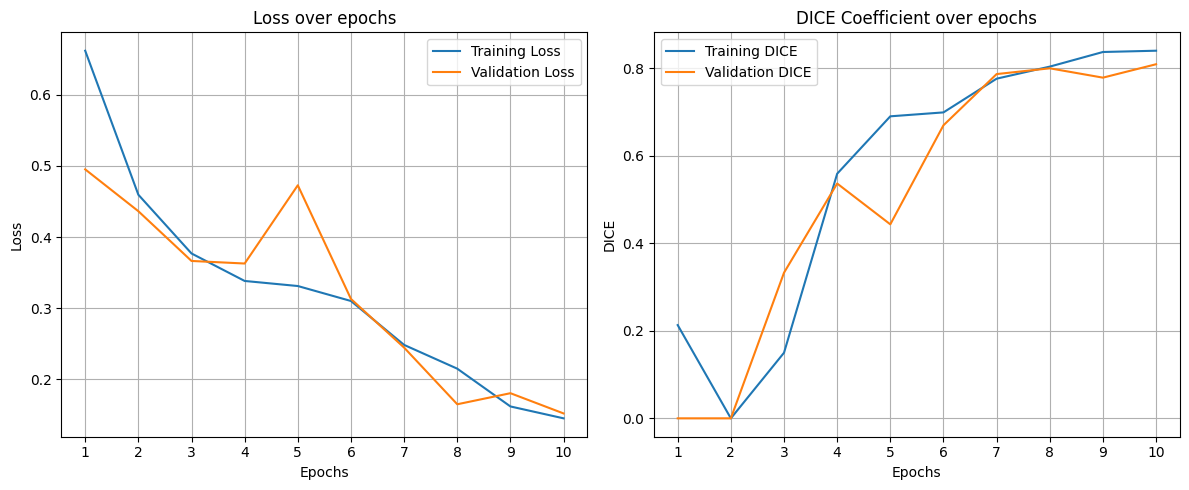

In [41]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Save the model
model_pth = '../models/U-net.pth'
# torch.save(model.state_dict(), model_pth)

In [17]:

trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

<All keys matched successfully>

In [18]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


In [ ]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model, device):

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]
    
    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    # image_paths.append(random_sample[2]) 


random_images_inference(image_tensors, mask_tensors, image_paths, model, device="cpu")
